In [1]:
import numpy as np
import matplotlib.pyplot as plt
import kcorrect
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u


%matplotlib inline

# this notebook is looking at how the final selection compares to the MGS in each band pass
# 0 sdss.modelMag_u, 
# 1 sdss.modelMag_r, 
# 2 sdss.petroMag_r, 
# 3 spec.z, 
# 4 sdss.petroR50_r, 
# 5 galex.fuv_mag, 
# 6 galex.nuv_mag, 
# 7 sdss.modelMag_u, 
# 8 sdss.modelMag_g,
# 9 sdss.modelMag_r,
# 10 sdss.modelMag_i,
# 11 sdss.modelMag_z
# 12 ukidss.yPetroMag, 
# 13 ukidss.j_1PetroMag,
# 14 ukidss.hPetroMag,
# 15 ukidss.kPetroMag,
# 16 wise.w1mpro ,  
# 17 wise.w2mpro , 
# 18 wise.w3mpro , 
# 19 wise.w4mpro , 
# 20 galex.fuv_magerr,
# 21 galex.nuv_magerr,
# 22 sdss.modelMagErr_u ,
# 23 sdss.modelMagErr_g , 
# 24 sdss.modelMagErr_r,
# 25 sdss.modelMagErr_i, 
# 26 sdss.modelMagErr_z,
# 27 ukidss.yPetroMagErr, 
# 28 ukidss.j_1PetroMagErr, 
# 29 ukidss.hPetroMagErr, 
# 30 ukidss.kPetroMagErr, 
# 31 wise.w1sigmpro, 
# 32 wise.w2sigmpro, 
# 33 wise.w3sigmpro, 
# 34 wise.w4sigmpro

In [2]:
cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3)

In [3]:
galaxies = np.load('/home/calum/Documents/Mphys_data/mgs_multiwavelength/mw_sample.npy')
galaxies.shape

(19082, 35)

In [4]:
# load filters before hand - too slow to (and pointless) to load each time

def perform_kcorrect(redshift,magnitudes,mag_ivars):
    # remember to apply AB magnitude offsets
    maggies = pow(10,-0.4*np.array(magnitudes))
    maggies_ivar = pow(0.4*np.log(10)*maggies*np.array(mag_ivars),-2)
    c = kcorrect.fit_nonneg(redshift,maggies,maggies_ivar)
    rm = kcorrect.reconstruct_maggies(c)
    rm0 = kcorrect.reconstruct_maggies(c,redshift=0.)
    #print(magnitudes)
    #print(-2.5*np.log10(rm[1:]),-2.5*np.log10(rm0[1:]))
    #print(-2.5*np.log10(rm[1:]/rm0[1:]))
    return -2.5*np.log10(rm[1:]/rm0[1:]) 

In [5]:
# save the k-corrections

kcorrections = []

kcorrect.load_templates()
kcorrect.load_filters(f='multiwavelength_filters.dat')

for row in galaxies:
    # calculate kcorrections
    ktuple = perform_kcorrect(row[3],row[5:16],row[20:31])
    # store in array
    kcorrections.append([row[3],ktuple])

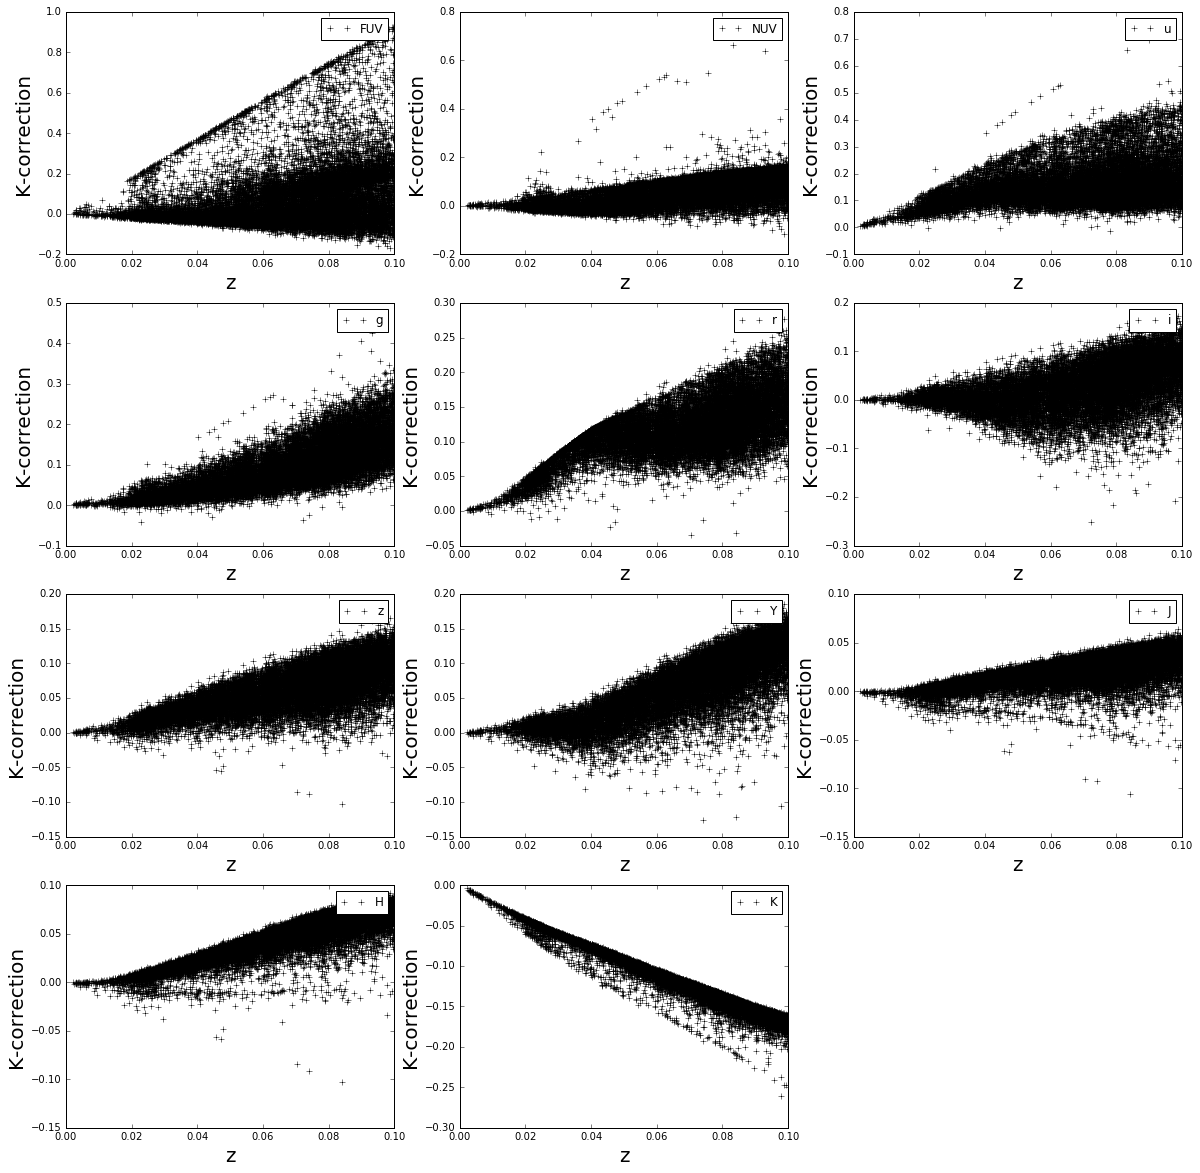

In [14]:
bands = ['FUV','NUV','u','g','r','i','z','Y','J','H','K','W1','W2']
plt.figure(figsize=(20,20))
for i,band in enumerate(bands[:-2]):
    plt.subplot(4,3,i+1)
    plt.plot([row[0] for row in kcorrections],[row[1][i] for row in kcorrections],'k+',label=band)
    plt.legend()
    plt.ylabel('K-correction',fontsize=20)
    plt.xlabel('z',fontsize=20)

In [38]:
def DM(z):
    return 5*(np.log10(cosmo.luminosity_distance(z).to(u.pc).value/10))

In [55]:
# calculate absolute magnitudes for each band
M_galaxies = []
# M = m-DM(z)-K(z)
for i,galaxy in enumerate(galaxies):
    M = []
    M.append(galaxy[3])
    for magidx,magnitude in enumerate(galaxy[5:18]):
        # calculate absolute magnitude
        #print(bands[magidx])
        if magidx < 11:
            M.append(galaxy[magidx+5]-DM(row[3])-kcorrections[i][1][magidx])
        else:
            M.append(galaxy[magidx+5]-DM(row[3]))
            
    M_galaxies.append(M)       

In [56]:
np.array(M_galaxies).shape

(19082, 14)

In [57]:
M_galaxies[0]

[0.075034983456134796,
 -19.166164593787954,
 -19.780723868886099,
 -20.829041826555596,
 -22.168458621034489,
 -22.889388266036377,
 -23.17023939897129,
 -23.491386565396652,
 -23.780184346268044,
 -24.088090847263203,
 -25.284718084165917,
 -25.097417774627075,
 -25.687596532533036,
 -25.975596639344559]

In [58]:
np.save('/home/calum/Documents/Mphys_data/mgs_multiwavelength/abs_mwsample.npy',M_galaxies)

In [53]:
inspect.getsourcefile(kcorrect)

'/home/calum/anaconda3/lib/python3.5/site-packages/kcorrect/__init__.py'